<a href="https://colab.research.google.com/github/xx529/Others/blob/main/GeekBang/chap02-homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 内容

1. 优化 target mean 算法过程
    * 用 Cython 加速
    * 加入并行
2. 使用 cython 实现对输入多列返回 B-spline basis 的操作。
    * 查看 B-spline 的介绍。 https://www.cs.unc.edu/~dm/UNC/COMP258/Papers/bsplbasic.pdf
    * 禁止使用函数 recursive call。 
    * 必须要处理异常情况（例如缺失值，inf 等）。


# 优化 target mean 算法

### 随机数据 1万条

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from collections import defaultdict

In [147]:
y = np.random.randint(2, size=(10000, 1))
x = np.random.randint(10, size=(10000, 1))
data = pd.DataFrame(np.concatenate([y, x], axis=1), columns=['y', 'x'])
comparison_dict = {'name':[], 'time':[]}

In [148]:
def cost(fun):
    def wrap(*arg):
        start = time.time()
        fun_result = fun(*arg)
        end = time.time()
        time_result = end-start
        return fun_result, time_result
    return wrap

In [149]:
data

,y,x
0,1,7
1,0,8
2,0,5
3,1,4
4,1,7
...,...,...
9995,0,4
9996,0,6
9997,1,6
9998,1,0


### Baseline v1

In [150]:
@cost
def target_mean_v1(data, y_name, x_name):
    result = np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        groupby_result = data[data.index != i].groupby([x_name], as_index=False).agg(['mean', 'count'])
        result[i] = groupby_result.loc[groupby_result.index == data.loc[i, x_name], (y_name, 'mean')]
    return result

In [151]:
%%time
baseline_ans, temp = target_mean_v1(data, 'y', 'x')
comparison_dict['name'].append('baseline_ans')
comparison_dict['time'].append(temp)

CPU times: user 48.8 s, sys: 12.7 ms, total: 48.8 s
Wall time: 48.9 s


### Baseline v2

In [152]:
@cost
def target_mean_v2(data, y_name, x_name):
    temp_dict = {}
    result = np.zeros(shape=data.shape[0])

    for i, row_data in data.iterrows():
        x_value, y_value = row_data[x_name], row_data[y_name]
        
        if x_value not in temp_dict:
            temp_dict[x_value] = {'sum': 0, 'count': 0}
        
        temp_dict[x_value]['sum'] += y_value
        temp_dict[x_value]['count'] += 1

    for i, row_data in data.iterrows():
        x_value, y_value = row_data[x_name], row_data[y_name]
        result[i] = np.array((temp_dict[x_value]['sum'] - y_value) / (temp_dict[x_value]['count'] - 1))
    
    return result

In [153]:
%%time
v2_ans, temp = target_mean_v2(data, 'y', 'x')
assert (baseline_ans == v2_ans).all()
print('---- correct ----')
comparison_dict['name'].append('baseline_v2')
comparison_dict['time'].append(temp)

---- correct ----
CPU times: user 1.41 s, sys: 1.99 ms, total: 1.42 s
Wall time: 1.42 s


### Python

In [167]:
@cost
def target_mean_python(data, y_name, x_name):
    sum_dict = defaultdict(int)
    count_dict = defaultdict(int)
    
    x_array = data[x_name].values
    y_array = data[y_name].values
    
    for x, y in zip(x_array, y_array):
        sum_dict[x] += y
        count_dict[x] += 1

    result = np.array([(sum_dict[x] - y) / (count_dict[x] - 1)for x, y in zip(x_array, y_array)])

    return result

In [169]:
%%time
python_ans, temp = target_mean_python(data, 'y', 'x')
assert (baseline_ans == python_ans).all()
print('---- correct ----')
comparison_dict['name'].append('python')
comparison_dict['time'].append(temp)

---- correct ----
CPU times: user 15.3 ms, sys: 0 ns, total: 15.3 ms
Wall time: 16.5 ms


### Pandas

In [170]:
@cost
def target_mean_pandas(data, y_name, x_name):
    temp = data.groupby(x_name).agg(['sum', 'count']).droplevel(0, axis=1).reset_index()
    
    df_target_mean = pd.DataFrame(dtype=float, columns=temp.columns+[y_name])  
    for target in data[y_name].unique():
        temp[y_name] = target
        df_target_mean = pd.concat([temp, df_target_mean], axis=0)
    
    df_target_mean['result'] = (df_target_mean['sum'] - df_target_mean[y_name]) / (df_target_mean['count'] - 1)
    result = pd.merge(data, df_target_mean, on=[y_name, x_name], how='left')['result'].values
    
    return result

In [171]:
%%time
pandas_ans, temp = target_mean_pandas(data, 'y', 'x')
assert (baseline_ans == pandas_ans).all()
print('---- correct ----')
comparison_dict['name'].append('pandas')
comparison_dict['time'].append(temp)

---- correct ----
CPU times: user 18.3 ms, sys: 2 ms, total: 20.3 ms
Wall time: 24 ms


### Cython_v1

In [128]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [205]:
%%cython

cpdef target_mean_cython_v1(data, x_name, y_name):
    cdef int row = data.shape[0]
    cdef int col = data.shape[1]
    cdef int[10000][2] array
    cdef int i, j
    
    for i in range(row):
        for j in range(col):
            array[i][j] = data.iloc[i,j]

    cdef int[10] count_list = [0,0,0,0,0,0,0,0,0,0]
    cdef int[10] sum_list = [0,0,0,0,0,0,0,0,0,0]
    cdef int x_value
    cdef int y_value

    for i in range(row):
        x_value = array[i][1]
        y_value = array[i][0]
        count_list[x_value] += 1
        sum_list[x_value] += y_value

    cdef double result[10000]
    for i in range(row):
        x_value = array[i][1]
        y_value = array[i][0]
        result[i] = <double> (sum_list[x_value] - y_value) / (count_list[x_value] - 1)
    
    return result

In [206]:
%%time
start = time.time()
assert (baseline_ans == np.array(target_mean_cython_v1(data, 'y', 'x'))).all()
end = time.time()
print('---- correct ----')
comparison_dict['name'].append('cython_v1')
comparison_dict['time'].append(end - start)

---- correct ----
CPU times: user 377 ms, sys: 3 ms, total: 380 ms
Wall time: 382 ms


## Cython_v2

In [204]:
%%cython -a

cimport numpy as cnp

cpdef target_mean_cython_v2(data, y_name, x_name):

    # return result


In [202]:
%%time
start = time.time()
assert (baseline_ans == np.array(target_mean_cython_v1(data, 'y', 'x'))).all()
end = time.time()
print('---- correct ----')
comparison_dict['name'].append('cython_v2')
comparison_dict['time'].append(end - start)

---- correct ----
CPU times: user 380 ms, sys: 983 µs, total: 381 ms
Wall time: 382 ms


### 结果量级对比

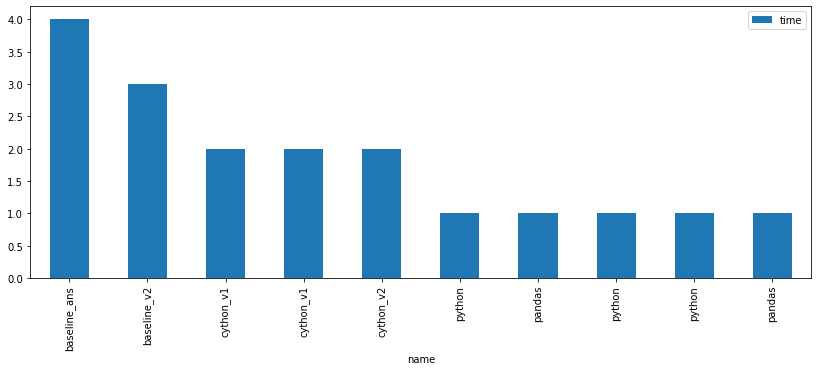

In [195]:
df = pd.DataFrame(comparison_dict)
df.index = df['name']
df['time'] = np.log10(df['time']*1000).astype('int')
df.sort_values('time', ascending=False).plot(kind='bar', figsize=(14, 5))
plt.show()

# B-spline basis 操作
